# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from string import punctuation
from nltk.corpus import stopwords
sw = stopwords.words("english")

In [2]:
# Add any additional import statements you need here
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "M1 Results"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
artist_files = {'cher':'cher_followers_data.txt',
'robyn':'robynkonichiwa_followers_data.txt'}

In [5]:
# Read in the lyrics data

# Initialize lists
artists = []
songs = []
lyrics = []

# Loop through each artist folder
for item in os.listdir(os.path.join(data_location, lyrics_folder)):
    full_artist_path = os.path.join(data_location, lyrics_folder, item)
    if os.path.isdir(full_artist_path):
        for lyric_page in os.listdir(full_artist_path):
            artist, song = lyric_page.split("_")
            song = song.replace(".txt", "")
            artists.append(artist)
            songs.append(song)

            # Construct full file path and read file
            file_path = os.path.join(full_artist_path, lyric_page)
            with open(file_path, encoding="utf-8") as infile:
                next(infile)  # Skip title
                next(infile)  # Skip blank line
                next(infile)  # Skip blank line
                next(infile)  # Skip final blank line
                lyrics.append(infile.read())

# Create DataFrame
lyrics_data = pd.DataFrame({
    'artist': artists,
    'song': songs,
    'lyrics': lyrics
})


In [6]:
# Read in the Twitter data for Cher
twitter_data_cher = pd.read_csv(
    os.path.join(data_location, twitter_folder, artist_files['cher']),
    sep="\t",
    quoting=3  # Ignore quote characters
)

# Add artist label
twitter_data_cher['artist'] = "cher"

In [7]:
# Read in the Twitter data for Robyn
twitter_data_robyn = pd.read_csv(
    os.path.join(data_location, twitter_folder, artist_files['robyn']),
    sep="\t",
    quoting=3  # Ignore quote characters
)

# Add artist label
twitter_data_robyn['artist'] = "robyn"

# Combine Cher and Robyn Twitter data
twitter_data = pd.concat([twitter_data_cher, twitter_data_robyn], ignore_index=True)

# Remove the temporary DataFrame
del twitter_data_robyn

In [8]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

# Initialize sentiment dictionary
sentiment = dict()

# Load positive words
with open(positive_words_file, 'r', encoding="utf-8") as infile:
    for idx, line in enumerate(infile):
        if line.startswith(";"):
            continue
        line = line.strip()
        if line and line.isalpha():
            sentiment[line] = 1

# Load negative words
with open(negative_words_file, 'r', encoding="utf-8") as infile:
    for idx, line in enumerate(infile):
        if line.startswith(";"):
            continue
        line = line.strip()
        if line and line.isalpha():
            sentiment[line] = -1

# Load words from tidy text lexicon
with open(tidy_text_file, 'r', encoding="utf-8") as infile:
    next(infile)  # Skip header
    for line in infile:
        word, sent, lexicon = line.strip().split("\t")
        if sent == "negative":
            sentiment[word] = -1
        elif sent == "positive":
            sentiment[word] = 1
        else:
            print(f"Got {word} with unknown sentiment '{sent}'.")


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [9]:
def get_sentiment(text, sent=sentiment):
   
    # Lowercase and split text into words
    words = [w.lower() for w in text.split()]

    # Sum sentiment scores for known words
    score = sum([sent[word] for word in words if word in sent])

    return score

In [10]:
lyrics_data['sentiment'] = lyrics_data['lyrics'].apply(get_sentiment)

In [11]:
avg_sentiment = lyrics_data.groupby('artist')['sentiment'].mean()
avg_sentiment

artist
cher     5.955696
robyn    7.644231
Name: sentiment, dtype: float64

##### Overall, which artist has the higher average sentiment per song? 

##### A: Robyn has the higher average sentiment per song.

In [12]:
# Cher's songs
first_artist = lyrics_data[lyrics_data['artist'] == 'cher'].copy()

# Calculate sentiment scores
first_artist['sentiment'] = first_artist['lyrics'].apply(get_sentiment)

# Sort by sentiment
sentiment_sort = first_artist.sort_values(by='sentiment')

# Get top 3 and bottom 3 songs by sentiment
top3_songs = sentiment_sort.tail(3)
bottom3_songs = sentiment_sort.head(3)

# Print lyrics of top 3 positive songs
print("\n--- Top 3 Positive Songs by Cher ---\n")
for _, row in top3_songs.iterrows():
    print(row['lyrics'])
    print("-" * 50)

# Print lyrics of bottom 3 negative songs
print("\n--- Bottom 3 Negative Songs by Cher ---\n")
for _, row in bottom3_songs.iterrows():
    print(row['lyrics'])
    print("-" * 50)



--- Top 3 Positive Songs by Cher ---

Hush little Baby, gotta be strong
'Cause in this world we are born to fight
Be the best, prove them wrong
A winner's work is never done, reach the top, number one

Oh, perfection
You drive me crazy with perfection
I've worn my pride as my protection
Perfection, ohh

I was taught to be tough
That the best that you can be ain't enough
Crack the whip, sacrifice
But I found out paradise had a price

I didn't know it then, but oh I know it now
You gotta work as hard as love to make the love work out
You know this heart of mine has made some big mistakes
I guess that when it comes to love, I just don't know what I takes

All my life I've been driven by perfection
Pushed it to the limit every day and night
Ohh, I've been driven by perfection
But nothing's perfect when love ain't right
Nothing's perfect when the love ain't right

Gave it all, played my part
I gave everything I had but my heart
Worked so hard, made a name
But the loneliness inside stays th

In [13]:
# Cher print("Top 3 Songs:")
top3_songs.song

198              perfection
108           ifoundyoulove
155    loveandunderstanding
Name: song, dtype: object

In [14]:
# Cher
print("Bottom 3 Songs:")
bottom3_songs.song

Bottom 3 Songs:


16                    bangbang
196                 outrageous
133    iwalkonguildedsplinters
Name: song, dtype: object

##### Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

##### A: Cher's top 3 songs are perfection, i found you love, and love and understanding. Her bottom 3 songs are bang bang, outrageous, and i walk on guilded splinters. Lyrics are shown above. Sentiment score is based on positivity of the words. Positive words result in a higher scores while negative words have lower sentiment scores.

In [15]:
# Robyn's songs
second_artist = lyrics_data[lyrics_data['artist'] == 'robyn'].copy()

# Calculate sentiment scores
second_artist['sentiment'] = second_artist['lyrics'].apply(get_sentiment)

# Sort by sentiment
sentiment_sort = second_artist.sort_values(by='sentiment')

# Get top 3 and bottom 3 songs by sentiment
top3_songs = sentiment_sort.tail(3)
bottom3_songs = sentiment_sort.head(3)

# Print lyrics of top 3 positive songs
print("\n--- Top 3 Positive Songs by Robyn ---\n")
for _, row in top3_songs.iterrows():
    print(row['lyrics'])
    print("-" * 50)

# Print lyrics of bottom 3 negative songs
print("\n--- Bottom 3 Negative Songs by Robyn ---\n")
for _, row in bottom3_songs.iterrows():
    print(row['lyrics'])
    print("-" * 50)


--- Top 3 Positive Songs by Robyn ---

We dance to the beat
We dance to the beat
We dance to the beat
We dance to the beat
We dance to the beat
We dance to the beat
We dance to the beat
We dance to the beat
We dance to the beat
We dance to the beat
We dance to the beat
We dance to the beat
We dance to the beat
We dance to the beat
We dance to the beat
We dance to the beat

We dance to the beat of the continents shifting under our feet
We dance to the beat
We dance to the beat
We dance to the beat of a new, better, faster breed
We dance to the beat
We dance to the beat
We dance to the beat of radioactivity blocking the exits
We dance to the beat
We dance to the beat
We dance to the beat of false math and unrecognised genius
We dance to the beat
We dance to the beat
We dance to the beat of distorted knowledge passed on
We dance to the beat
We dance to the beat
We dance to the beat of a distant rumble
We dance to the beat
We dancing
And it's loud and proud
And it's loud and proud
And it'

In [16]:
# Robyn
print("Top 3 Songs:")
top3_songs.song

Top 3 Songs:


414          wedancetothebeat
415    wedancetothebeat114528
380                loveisfree
Name: song, dtype: object

In [17]:
# Robyn
print("Bottom 3 Songs:")
bottom3_songs.song

Bottom 3 Songs:


343    dontfuckingtellmewhattodo114520
342          dontfuckingtellmewhattodo
334                     criminalintent
Name: song, dtype: object

##### Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

##### A: Robyn's top 3 songs are we dance to the beat, we dance to the beat 114528, and love is free. Bottom 3 songs are Don't F-ing Tell Me What to Do 114520, Don't F-ing Tell Me What to Do, and Criminial Intent. Sentiment score is based on positivity of the words. Positive words result in a higher scores (dance, love, free) while negative words (don't, F-ing, criminal) have lower sentiment scores.

##### Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

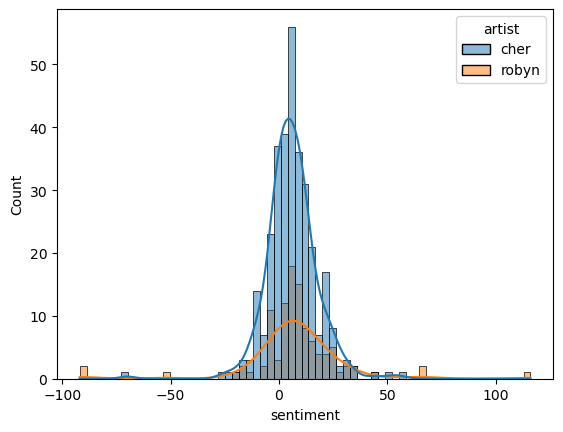

In [18]:
# distribution plot of sentiment scores
sns.histplot(data=lyrics_data, x='sentiment', hue='artist', kde=True)
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [19]:
# Define positive and negative emoji sets (at least 10 each)
positive_emojis = {'😊', '❤️', '😍', '😂', '🥰', '👍', '😁', '🎉', '😎', '✨'}
negative_emojis = {'😡', '💔', '😢', '😭', '😠', '👎', '😞', '😣', '😤', '😩'}

# Combine into a sentiment dictionary
emoji_sentiment = dict(zip(positive_emojis, [1]*len(positive_emojis)))
emoji_sentiment.update(dict(zip(negative_emojis, [-1]*len(negative_emojis))))

# Function to calculate emoji-based sentiment for a single description
def get_desc_sentiment(desc,sent=emoji_sentiment) :
    return sum([sent[ch] for ch in str(desc) if ch in sent])

# Function to extract emojis from descriptions
def extract_emojis(desc, emoji_list):
    return [ch for ch in str(desc) if ch in emoji_list]

# Apply the sentiment scoring to each description
twitter_data['sentiment'] = twitter_data.description.apply(get_desc_sentiment)
twitter_data['pos_emoji'] = twitter_data.description.apply(extract_emojis,args=(positive_emojis,))
twitter_data['neg_emoji'] = twitter_data.description.apply(extract_emojis,args=(negative_emojis,))

twitter_data.query('sentiment > 0').head()

,screen_name,name,id,location,followers_count,friends_count,description,artist,sentiment,pos_emoji,neg_emoji
10,notdevilanse,Amanda 😇,916870029123211264,NaN,13,110,do what thou wilt. 🖤✨,cher,1,[✨],[]
51,tayissbae,t a y b a e,3192778760,always moving,530,410,✨🧚🏼‍♂️ 🌷🦄🎀🦕🌺💝🍒🌸🧸🍑,cher,1,[✨],[]
77,EmmaWhiteMusic,EMMA WHITE,24169471,"Nashville, TN",5504,210,“Thirties” & “Mothers & Daughters” out now ✨ s...,cher,1,[✨],[]
115,SpenseRon,ron spense,1428472797152612352,toronto,684,1573,"I've played by the rules; worked hard, stood u...",cher,3,"[😎, 😎, 😎]",[]
175,salma_haniff,sally,236538644,"Queens, NY",214,592,💽🌿🐛💌✨,cher,1,[✨],[]


In [20]:
twitter_data.query('sentiment < 0').head()

,screen_name,name,id,location,followers_count,friends_count,description,artist,sentiment,pos_emoji,neg_emoji
168,Mermarietho,Spoopy Jim 𓆏,722620867507724288,Crack House,54,266,"I just love my dog, man😭💖",cher,-1,[],[😭]
271,CynchaBlue,Cyncha,1500244117871288322,NaN,151,430,"Grandma, great grandma, Air Force veteran, ret...",cher,-1,[],[👎]
1668,NenaTs2418,T.N. DeLaRosa🌹,1291609241204252674,Planet Pluto,11,279,"Nene, that is all♥️ R.I.P mí amor💔 🇲🇽/🇺🇸 I wil...",cher,-1,[],[💔]
2899,Bunnysishi,Sishi Unterberg Choi,19849954,"San Diego, CA",28,227,♡.(✿╹◡╹)ﾉ★☆.｡₀:*ﾟ✲ﾟ*:𝔉𝔞𝔪𝔦𝔩𝔶❤︎𝔉𝔞𝔰𝔥𝔦𝔬𝔫❤︎𝔉𝔢𝔢𝔩𝔦𝔫𝔤❤...,cher,-1,[],[💔]
4818,The2Sixteen,Jeffrey Grant 🗝,30232486,"Rhode Island, USA",9498,9953,Former Surf/Model Photographer ♥️ 2019 Cardiac...,cher,-1,[],[💔]


In [21]:
# average sentiment by artist
twitter_data.groupby('artist')['sentiment'].mean()

artist
cher     0.014482
robyn    0.009365
Name: sentiment, dtype: float64

In [24]:
# Explode pos_emoji and neg_emoji separately
pos_emoji_exploded = twitter_data[['artist', 'pos_emoji']].explode('pos_emoji')
neg_emoji_exploded = twitter_data[['artist', 'neg_emoji']].explode('neg_emoji')

# Count most common emojis by artist using value_counts().groupby().head(1)
top_positive = (
    pos_emoji_exploded
    .groupby('artist')['pos_emoji']
    .value_counts()
    .groupby('artist')
    .head(1)
)

top_negative = (
    neg_emoji_exploded
    .groupby('artist')['neg_emoji']
    .value_counts()
    .groupby('artist')
    .head(1)
)

#  Display results
print("\nMost Positive Emoji per Artist:")
print(top_positive)

print("\nMost Negative Emoji per Artist:")
print(top_negative)



Most Positive Emoji per Artist:
artist  pos_emoji
cher    ✨            29468
robyn   ✨             2223
Name: count, dtype: int64

Most Negative Emoji per Artist:
artist  neg_emoji
cher    💔            1611
robyn   💔              60
Name: count, dtype: int64


##### Q: What is the average sentiment of your two artists? 

##### A: Cher is slightly higher. Average sentiment of Cher is 0.014482 and Robyn is 0.009365


##### Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

##### A: Both Cher and Robyn have the same most popular positive emoji, star ✨, and same negative emoji , broken heart 💔.